In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy import signal

In [3]:
import theano
from theano import tensor as T
import lasagne
from lasagne.layers import InputLayer, Conv2DLayer

In [4]:
from skimage.io import imread

(-0.5, 511.5, 511.5, -0.5)

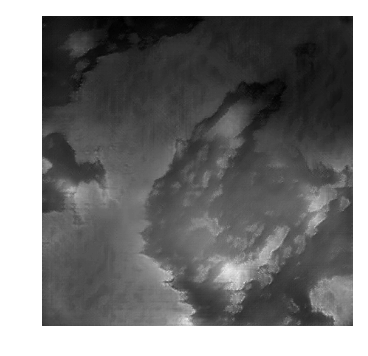

In [10]:
hm = imread("18.png")[:,:,0]
hm = hm.astype("float32") / 255.
plt.imshow(hm,cmap="gray")
plt.axis('off')

In [81]:
hm.shape

(512, 512, 3)

In [8]:
l_in = InputLayer((None, 1, 512, 512))
l_conv = Conv2DLayer(l_in, num_filters=1, filter_size=7, pad='same')

In [9]:
l_conv.W.get_value().shape

(1, 1, 7, 7)

In [97]:
?np.linspace

In [10]:
import scipy.stats as st

def gkern(kernlen=21, nsig=3, debug=False):
    """Returns a 2D Gaussian kernel array."""

    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    if debug:
        print x
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [11]:
f = l_conv.W.get_value()
f[0,0,:,:] = gkern(l_conv.W.get_value().shape[-1],3)
l_conv.W.set_value(f)

In [12]:
conv_out = lasagne.layers.get_output(l_conv, l_conv.input_layer.input_var)

In [15]:
tmp = conv_out.eval({l_conv.input_layer.input_var: hm[np.newaxis,np.newaxis]})

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /Users/cjb60/.theano/compiledir_Darwin-14.0.0-x86_64-i386-64bit-i386-2.7.13-64/tmpmKtJuA/key.pkl
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '2704' (I am process '4828')


(-0.5, 511.5, 511.5, -0.5)

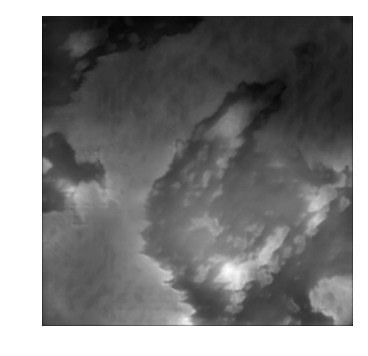

In [16]:
plt.imshow(tmp[0][0],cmap="gray")
plt.axis('off')

In [22]:
np.random.uniform()

array([   1.        ,    1.        ,  380.61704384,  358.97069287])

In [23]:
tmp = conv_out.eval({l_conv.input_layer.input_var: np.random.uniform(size=(1,1,512,512))})

----

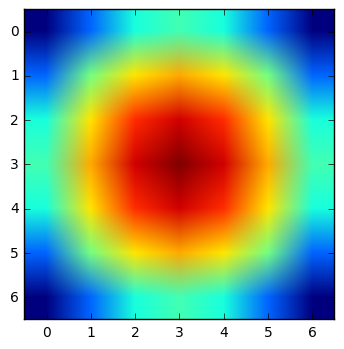

In [101]:
plt.imshow(gkern(l_conv.W.get_value().shape[-1],1))

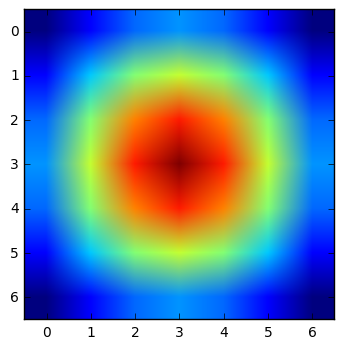

In [102]:
plt.imshow(gkern(l_conv.W.get_value().shape[-1],2))

[-3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5]


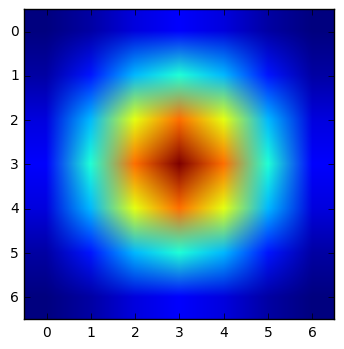

In [111]:
plt.imshow(gkern(l_conv.W.get_value().shape[-1],3, debug=True))

In [17]:
lasagne.layers.get_all_params(l_conv, trainable=True)

[W, b]

OrderedDict([(W, {'regularizable', 'trainable'}), (b, {'trainable'})])

In [40]:
X = T.tensor4('X')
ups = theano.tensor.nnet.abstract_conv.bilinear_upsampling(X, 10).eval({
    X: hm[np.newaxis][np.newaxis]
})

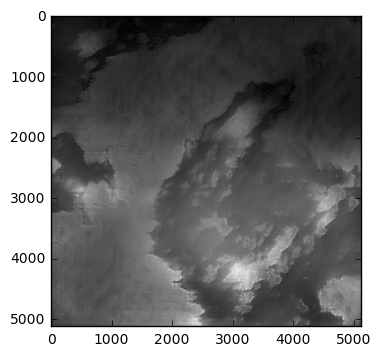

In [41]:
plt.imshow(ups[0][0],cmap="gray")

-------

In [5]:
from lasagne.layers import Layer

In [24]:
class BilinearUpsample2DLayer(Layer):
    def __init__(self, incoming, factor, **kwargs):
        super(BilinearUpsample2DLayer, self).__init__(incoming, **kwargs)
        self.factor = factor

    def get_output_shape_for(self, input_shape):
        return input_shape[0:2] + \
            (input_shape[2]*self.factor if input_shape[2] != None else None,
             input_shape[3]*self.factor if input_shape[3] != None else None)

    def get_output_for(self, input, **kwargs):
        return theano.tensor.nnet.abstract_conv.bilinear_upsampling(
            input, 
            self.factor, 
            batch_size=self.input_shape[0],
            num_input_channels=self.input_shape[1])

In [18]:
X = T.tensor4('X')
l_in = InputLayer((None, 1, 512, 512))
l_ups = BilinearUpsample2DLayer(l_in, 2)
l_inv = lasagne.layers.InverseLayer(l_ups, l_ups)
ups_out = lasagne.layers.get_output(l_ups, X)

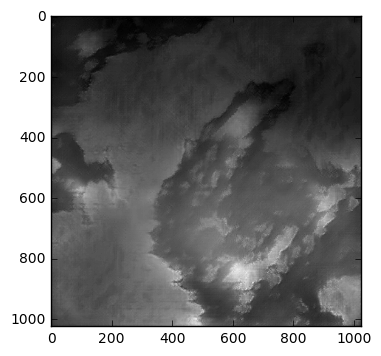

In [16]:
plt.imshow(ups_out.eval({X:hm[np.newaxis][np.newaxis]})[0][0],cmap="gray")

In [27]:
X = T.tensor4('X')
l_in = InputLayer((None, 1, None, None))
l_ups = BilinearUpsample2DLayer(l_in, 0)
l_inv = lasagne.layers.InverseLayer(l_ups, l_ups)
ups_out = lasagne.layers.get_output(l_ups, X)

In [28]:
ups_out.eval({X:np.random.normal(0,1,size=(2,1,512,256))}).shape

ValueError: CorrMM backprop wrt. inputs: impossible output shape
  bottom shape: 2 x 1 x 0 x 258
  weights shape: 1 x 1 x 0 x 1
  top shape: 2 x 1 x 514 x 258

Apply node that caused the error: CorrMM_gradInputs{valid, (0, 1), (1, 1)}(Subtensor{::, ::, ::int64, ::int64}.0, Join.0, Subtensor{int64}.0, Subtensor{int64}.0)
Toposort index: 24
Inputs types: [TensorType(float64, (True, True, False, True)), TensorType(float64, (False, True, False, False)), TensorType(int64, scalar), TensorType(int64, scalar)]
Inputs shapes: [(1, 1, 0, 1), (2, 1, 514, 258), (), ()]
Inputs strides: [(0, 0, -8, -8), (1060896, 1060896, 2064, 8), (), ()]
Inputs values: [array([], shape=(1, 1, 0, 1), dtype=float64), 'not shown', array(0), array(258)]
Outputs clients: [[CorrMM_gradInputs{valid, (1, 0), (1, 1)}(Subtensor{::, ::, ::int64, ::int64}.0, CorrMM_gradInputs{valid, (0, 1), (1, 1)}.0, Subtensor{int64}.0, Subtensor{int64}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/cjb60/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/cjb60/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/cjb60/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/cjb60/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-47b48b8b8244>", line 5, in <module>
    ups_out = lasagne.layers.get_output(l_ups, X)
  File "/Users/cjb60/anaconda2/lib/python2.7/site-packages/Lasagne-0.2.dev1-py2.7.egg/lasagne/layers/helper.py", line 191, in get_output
    all_outputs[layer] = layer.get_output_for(layer_inputs, **kwargs)
  File "<ipython-input-24-ba345316ebcf>", line 15, in get_output_for
    num_input_channels=self.input_shape[1])

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.